# Toy example

Original notebook by Alexander Held, edited for the MadMiner repository by Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

In this notebook, we use a simple toy example to demonstrate the machine learning and inference algorithms in MadMiner. This allows us to skip many of the more technical steps, and there's no dependency on MadGraph, Pythia, or Delphes.

What this tutorial does not do, is explaining the inference methods. To understand what's happening, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013), which will explain the basic idea in just a few pages. If you really want to get down to the dirty details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) has you covered.

## Preparations

In [23]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline
import sys
sys.path.append('/remote/gpu02/crescenzo/MadMiner')

from madminer.ml import ParameterizedRatioEstimator

In [24]:
if not os.path.exists("data_standard_close"):
    os.makedirs("data_standard_close")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [25]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. A toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

As in the particle physics case, we assume that we can calculate the joint likelihood ratio `r(x, z | theta0, theta1)` as well as the joint score `t(x, z | theta)`, which depend explicitly on `z` (and where the "detector" part cancels).

Here are some general settings (feel free to play with them): 

In [26]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta` and calculates the joint likelihood ratio between `theta0` and `theta1` as well as the joint score at `theta_score`:

In [27]:
alpha=1

In [28]:
npoints = 100

In [29]:
theta = 100

In [30]:
z1 = np.random.normal(loc=0, scale=z_std, size=npoints)
z2 = np.random.normal(loc=alpha, scale=z_std, size=npoints)
mask = np.random.choice([True, False],p=[1./(1+theta**2),theta**2/(1+theta**2)],size=npoints)

In [31]:
z1[mask].flatten()

array([], dtype=float64)

In [32]:
np.concatenate((z1[mask],z2[~mask]))

array([ 1.12144653,  0.65490702,  3.47424776,  2.94428479, -0.36313933,
       -0.0221043 ,  3.09129771,  0.08130752,  0.65376787,  1.07264247,
        1.10738633,  1.94531393,  0.68303793,  3.37326635,  2.1280687 ,
       -2.19890295,  0.67622576,  0.63128235,  0.45027539,  2.26454169,
       -2.06656928, -0.5881494 ,  4.01713772,  2.60039456, -0.4927823 ,
       -1.92986251,  1.88114304,  4.73580347, -1.36516616,  4.33947144,
        0.32422606, -0.00573751,  1.90025423,  0.41993304,  2.17979541,
       -2.64488152, -1.45606717,  1.33139417,  4.4129273 ,  3.92372296,
        2.2401928 ,  1.02909794, -0.36391556,  0.93627185,  2.17911815,
        1.23683962,  0.53544924,  2.24116956,  0.61264893, -2.72050123,
        1.95495438, -1.93277117,  0.68283854, -2.21361412,  2.24470051,
        4.39102324,  3.83597843, -0.00513241, -0.19657072,  4.03254072,
        0.55094801,  0.11532365, -1.44285507,  0.17349113,  1.75383002,
        2.55363214,  2.43655892,  2.62629077,  3.60988493,  2.54

In [33]:
np.random.choice([True,False],p = [0.5,0.5],size = None)

False

In [34]:
def simulate(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z1 = np.random.normal(loc=0, scale=z_std, size=npoints)
    z2 = np.random.normal(loc=alpha, scale=z_std, size=npoints)
    mask = np.random.choice([True, False],p=[1./(1+theta**2),theta**2/(1+theta**2)],size=npoints)
    try:
        z = np.concatenate((z1[mask],z2[~mask]))
    except:
        if mask:
            z = z1
        else:
            z = z2
    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    # Calculate joint likelihood ratio and joint score
    if theta0 is not None and theta1 is not None:
        r_xz = (norm(loc=theta1, scale=z_std).pdf(z)+(theta0**2)*norm(loc=alpha, scale=z_std).pdf(z) )/ ((1+theta0**2)*norm(loc=theta1, scale=z_std).pdf(z))
    else:
        r_xz = None

    if theta_score is not None:
        t_xz = (x - theta_score) / z_std**2
    else:
        t_xz = None

    return x, r_xz, t_xz

Usually the likelihood function `p(x|theta)` is intractable, but in this toy example it is just given by the convolution of two Gaussians, which is again a Gaussian. We will use this to validate the results later:

In [35]:
def calculate_likelihood_ratio(x, theta0, theta1=0.0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = (norm(loc=theta1, scale=combined_std).pdf(x)+(theta0**2)*norm(loc=alpha, scale=combined_std).pdf(x) )/ ((1+theta0**2)*norm(loc=theta1, scale=combined_std).pdf(x))
    return r_x

Let's now visualize that: we run the simulation and plot the probability distributions $p(x | \theta_i)$. Additionally, we also plot the true log-likelihood ratio $\log\,r(x|\theta_0,\theta_1)$. 

/tmp/ipykernel_2877174/413034781.py:3: RuntimeWarning: divide by zero encountered in divide
  r_x = (norm(loc=theta1, scale=combined_std).pdf(x)+(theta0**2)*norm(loc=alpha, scale=combined_std).pdf(x) )/ ((1+theta0**2)*norm(loc=theta1, scale=combined_std).pdf(x))
/tmp/ipykernel_2877174/413034781.py:3: RuntimeWarning: invalid value encountered in divide
  r_x = (norm(loc=theta1, scale=combined_std).pdf(x)+(theta0**2)*norm(loc=alpha, scale=combined_std).pdf(x) )/ ((1+theta0**2)*norm(loc=theta1, scale=combined_std).pdf(x))


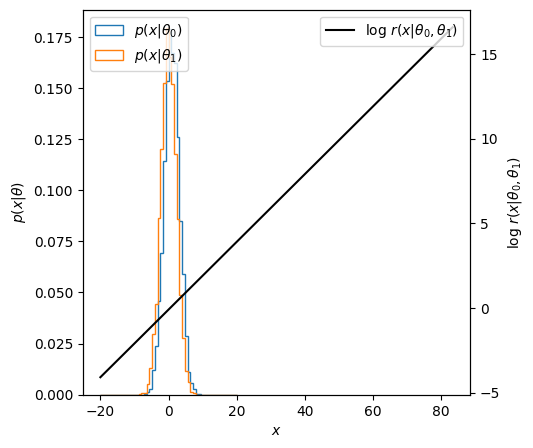

In [36]:
x0, _, _ = simulate(100, npoints=10000)
x1, _, _ = simulate(0, npoints=10000)

xr = np.linspace(-20.0, 300.0, 100)
rx = np.log(calculate_likelihood_ratio(xr, 100, 0))

fig, ax1 = plt.subplots()
fig.set_size_inches(5, 5)
ax1.set_xlabel("$x$")
ax1.hist(x0, bins=50, range=(-20, 20.0), histtype="step", label=r"$p(x | \theta_0)$", density=True)
ax1.hist(x1, bins=50, range=(-20, 20.0), histtype="step", label=r"$p(x | \theta_1)$", density=True)
ax1.set_ylabel(r"$p(x|\theta)$")
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xr, rx, color="black", label=r"$\log\,r(x|\theta_0,\theta_1)$")
ax2.set_ylabel(r"$\log\,r(x|\theta_0,\theta_1)$")
ax2.legend(loc=1)

plt.show()

In [37]:
x0.shape

(10000,)

## 2. Run the simulation and generate training data

First, we define the parameter points we want to use for training: `theta0` is uniformly distributed while the reference model `theta1` is fixed at zero. 

In [38]:
# number of parameter points to train
n_param_points = 50000

# numerator, uniform prior
theta0 = np.random.uniform(low=-4.0, high=4.0, size=n_param_points)

# denominator: fixed at 0
theta1 = np.zeros(shape=n_param_points)

We then run the simulator (one sample per parameter point). Remember that `simulate(theta, theta0, theta1, theta_score)` generates data `x` following a theory with `theta` and then evaluates the joint likelihood ratio `r(x,z|theta0,theta1)` and the join score `t(x,z|theta_score)` for each data point.

In [39]:
# Sample from theta0
x_from_theta0 = []
r_xz_from_theta0 = []
t_xz_from_theta0 = []
x_from_theta1 = []
r_xz_from_theta1 = []
t_xz_from_theta1 = []
for t in theta0:
    out = simulate(t, t, 0., t)
    x_from_theta0.append(out[0])
    r_xz_from_theta0.append(out[1])
    t_xz_from_theta0.append(out[2])
print("Done first sim")
for t,_ in zip(theta1,theta0):
    out = simulate(t, _, t, _)
    x_from_theta1.append(out[0])
    r_xz_from_theta1.append(out[1])
    t_xz_from_theta1.append(out[2])

Done first sim


Now we combine and reshape the results (nothing interesting happening here) and save everything to files, so that we can load it later.

In [40]:
# Combine results and reshape
x_train = np.hstack((x_from_theta0, x_from_theta1)).reshape(-1, 1)
r_xz_train = np.hstack((r_xz_from_theta0, r_xz_from_theta1)).reshape(-1, 1)
t_xz_train = np.hstack((t_xz_from_theta0, t_xz_from_theta1)).reshape(-1, 1)
y_train = np.hstack((np.zeros_like(x_from_theta0), np.ones_like(np.ones_like(x_from_theta1)))).reshape(-1, 1)
theta0_train = np.hstack((theta0, theta0)).reshape(-1, 1)

# Save to file
np.save("data_standard_close/theta0_train.npy", theta0_train)
np.save("data_standard_close/x_train.npy", x_train)
np.save("data_standard_close/y_train.npy", y_train)
np.save("data_standard_close/r_xz_train.npy", r_xz_train)
np.save("data_standard_close/t_xz_train.npy", t_xz_train)

In [41]:
theta0_train.shape

(100000, 1)

## 3. Model training

Let's train two neural networks to estimate the likelihood ratio. For one we use the CARL method introduced in ["Approximating Likelihood Ratios with Calibrated Discriminative Classifiers"](https://arxiv.org/abs/1506.02169), for the other the new ALICES method introduced in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973).

In [54]:
carl = ParameterizedRatioEstimator(n_hidden=(20, 20))

loss_carl = carl.train(
    method="carl",
    x="data_standard_close/x_train.npy",
    y="data_standard_close/y_train.npy",
    theta="data_standard_close/theta0_train.npy",
    n_epochs=20,
)

carl.save("models_standard_close/carl")

10:11 madminer.ml.paramete INFO    Starting training
10:11 madminer.ml.paramete INFO      Method:                 carl
10:11 madminer.ml.paramete INFO      Batch size:             128
10:11 madminer.ml.paramete INFO      Optimizer:              amsgrad
10:11 madminer.ml.paramete INFO      Epochs:                 20
10:11 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
10:11 madminer.ml.paramete INFO      Validation split:       0.25
10:11 madminer.ml.paramete INFO      Early stopping:         True
10:11 madminer.ml.paramete INFO      Scale inputs:           True
10:11 madminer.ml.paramete INFO      Scale parameters:       True
10:11 madminer.ml.paramete INFO      Shuffle labels          False
10:11 madminer.ml.paramete INFO      Samples:                all
10:11 madminer.ml.paramete INFO    Loading training data
10:11 madminer.utils.vario INFO      Loading data_standard_close/theta0_train.npy into RAM
10:11 madminer.utils.vario INFO      Loadi

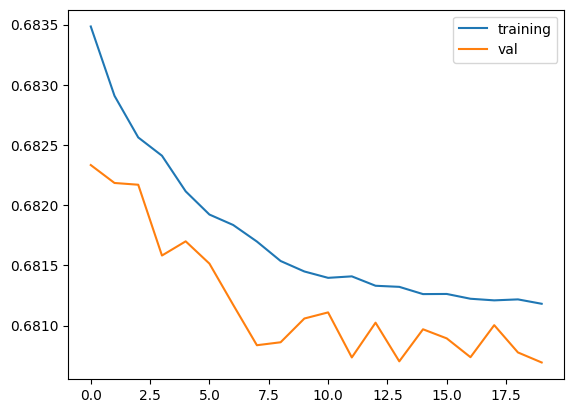

In [55]:
plt.plot(loss_carl[0],label="training")
plt.plot(loss_carl[1],label="val")
plt.legend()

In [56]:
alices = ParameterizedRatioEstimator(n_hidden=(20, 20))

loss_alice = alices.train(
    method="alice",
    x="data_standard_close/x_train.npy",
    y="data_standard_close/y_train.npy",
    theta="data_standard_close/theta0_train.npy",
    r_xz="data_standard_close/r_xz_train.npy",
    t_xz="data_standard_close/t_xz_train.npy",
    alpha=0.1,
    n_epochs=20,
)

alices.save("models_standard_close/alices")

10:12 madminer.ml.paramete INFO    Starting training
10:12 madminer.ml.paramete INFO      Method:                 alice
10:12 madminer.ml.paramete INFO      Batch size:             128
10:12 madminer.ml.paramete INFO      Optimizer:              amsgrad
10:12 madminer.ml.paramete INFO      Epochs:                 20
10:12 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0001
10:12 madminer.ml.paramete INFO      Validation split:       0.25
10:12 madminer.ml.paramete INFO      Early stopping:         True
10:12 madminer.ml.paramete INFO      Scale inputs:           True
10:12 madminer.ml.paramete INFO      Scale parameters:       True
10:12 madminer.ml.paramete INFO      Shuffle labels          False
10:12 madminer.ml.paramete INFO      Samples:                all
10:12 madminer.ml.paramete INFO    Loading training data
10:12 madminer.utils.vario INFO      Loading data_standard_close/theta0_train.npy into RAM
10:12 madminer.utils.vario INFO      Load

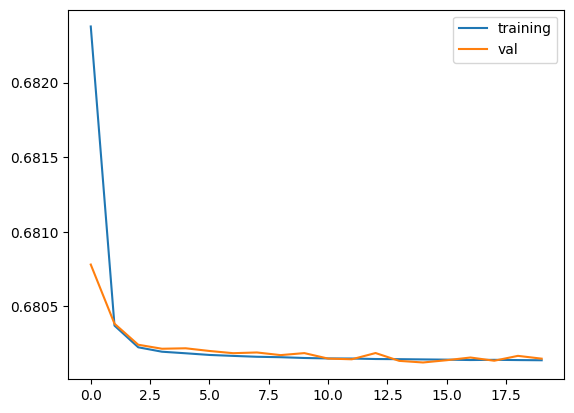

In [57]:
plt.plot(loss_alice[0],label="training")
plt.plot(loss_alice[1],label="val")
plt.legend()

We can also try a little bit of mixing and matching -- let's train a model with CARL first and then with ALICES:

In [59]:
mix = ParameterizedRatioEstimator(n_hidden=(20, 20))

loss_1 = mix.train(
    method="carl",
    x="data_standard_close/x_train.npy",
    y="data_standard_close/y_train.npy",
    theta="data_standard_close/theta0_train.npy",
    n_epochs=10,
    initial_lr=0.001,
    final_lr=0.0003,
)

loss_2 = mix.train(
    method="alice",
    x="data_standard_close/x_train.npy",
    y="data_standard_close/y_train.npy",
    theta="data_standard_close/theta0_train.npy",
    r_xz="data_standard_close/r_xz_train.npy",
    t_xz="data_standard_close/t_xz_train.npy",
    alpha=0.1,
    n_epochs=10,
    initial_lr=0.0003,
    final_lr=0.0001,
)
mix.save("models_standard_close/mix")

10:17 madminer.ml.paramete INFO    Starting training
10:17 madminer.ml.paramete INFO      Method:                 carl
10:17 madminer.ml.paramete INFO      Batch size:             128
10:17 madminer.ml.paramete INFO      Optimizer:              amsgrad
10:17 madminer.ml.paramete INFO      Epochs:                 10
10:17 madminer.ml.paramete INFO      Learning rate:          0.001 initially, decaying to 0.0003
10:17 madminer.ml.paramete INFO      Validation split:       0.25
10:17 madminer.ml.paramete INFO      Early stopping:         True
10:17 madminer.ml.paramete INFO      Scale inputs:           True
10:17 madminer.ml.paramete INFO      Scale parameters:       True
10:17 madminer.ml.paramete INFO      Shuffle labels          False
10:17 madminer.ml.paramete INFO      Samples:                all
10:17 madminer.ml.paramete INFO    Loading training data
10:17 madminer.utils.vario INFO      Loading data_standard_close/theta0_train.npy into RAM
10:17 madminer.utils.vario INFO      Loadi

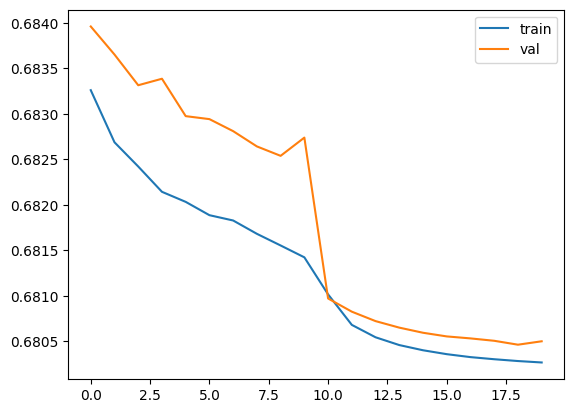

In [64]:
loss_train_mix = np.concatenate((loss_1[0],loss_2[0]))
loss_val_mix = np.concatenate((loss_1[1],loss_2[1]))
plt.plot(loss_train_mix,label="train")
plt.plot(loss_val_mix,label="val")
plt.legend()

## 4. Generate evaluation data

Let us now generate some test data, which is sampled corresponding to `theta=1`

In [65]:
n_param_points_test = 1000  # number of parameter points to test
theta_test = 1.0 * np.ones(shape=n_param_points_test)

Run the simulator to get observations:

In [66]:
x_test = []
for t in theta_test:
    x_test.append(simulate(t)[0])
np.save("data_standard_close/x_test.npy", x_test)

We want to evaluate the expected likelihood ratio on a range of parameter points:

In [67]:
theta_grid = np.linspace(-5.0, 5.0, 100).reshape(-1, 1)
np.save("data_standard_close/theta_grid.npy", theta_grid)

In this toy example, we can calculate the true likelihood ratio. We will save the expected log likelihood ratio (multiplied with a conventional factor of -2):

In [68]:
all_log_r_test_true = []
nllr_test_true = []

for theta in theta_grid:
    log_r = np.log(calculate_likelihood_ratio(x_test, theta))
    nllr_test_true.append(-2.0 * np.mean(log_r))
    all_log_r_test_true.append(log_r)

all_log_r_test_true = np.asarray(all_log_r_test_true).reshape((100, n_param_points_test))
nllr_test_true = np.asarray(nllr_test_true)

## 5. Evaluation

It's time to evaluate our likelihood ratio estimators!

In [69]:
carl = ParameterizedRatioEstimator()
carl.load("models_standard_close/carl")

log_r, _ = carl.evaluate(
    theta="data_standard_close/theta_grid.npy",
    x="data_standard_close/x_test.npy",
    evaluate_score=False,
)

nllr_test_carl = -2.0 * np.mean(log_r, axis=1)
mse_carl = np.mean((all_log_r_test_true - log_r) ** 2)
print("MSE:", mse_carl)

10:19 madminer.ml.base     INFO    Loading model from models_standard_close/carl
10:19 madminer.utils.vario INFO      Loading data_standard_close/x_test.npy into RAM
10:19 madminer.utils.vario INFO      Loading data_standard_close/theta_grid.npy into RAM


MSE: 0.0052446077033289976


In [70]:
alices = ParameterizedRatioEstimator()
alices.load("models_standard_close/alices")

log_r, _ = alices.evaluate(
    theta="data_standard_close/theta_grid.npy",
    x="data_standard_close/x_test.npy",
    evaluate_score=False,
)

nllr_test_alices = -2.0 * np.mean(log_r, axis=1)
mse_alices = np.mean((all_log_r_test_true - log_r) ** 2)
print("MSE:", mse_alices)

10:19 madminer.ml.base     INFO    Loading model from models_standard_close/alices
10:19 madminer.utils.vario INFO      Loading data_standard_close/x_test.npy into RAM
10:19 madminer.utils.vario INFO      Loading data_standard_close/theta_grid.npy into RAM


MSE: 0.0002775592049797281


In [71]:
mix = ParameterizedRatioEstimator()
mix.load("models_standard_close/mix")

log_r, _ = mix.evaluate(
    theta="data_standard_close/theta_grid.npy",
    x="data_standard_close/x_test.npy",
    evaluate_score=False,
)

nllr_test_mix = -2.0 * np.mean(log_r, axis=1)
mse_mix = np.mean((all_log_r_test_true - log_r) ** 2)
print("MSE:", mse_mix)

10:19 madminer.ml.base     INFO    Loading model from models_standard_close/mix
10:19 madminer.utils.vario INFO      Loading data_standard_close/x_test.npy into RAM
10:19 madminer.utils.vario INFO      Loading data_standard_close/theta_grid.npy into RAM


MSE: 0.0016577332515032123


This is the expected log likelihood ratio over parameter space:

/tmp/ipykernel_2877174/1526069039.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_fit_alices = float(theta_grid[np.argmin(nllr_test_alices)])
/tmp/ipykernel_2877174/1526069039.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_fit_carl = float(theta_grid[np.argmin(nllr_test_carl)])
/tmp/ipykernel_2877174/1526069039.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_fit_mix = float(theta_grid[np.argmin(nllr_test_mix)])


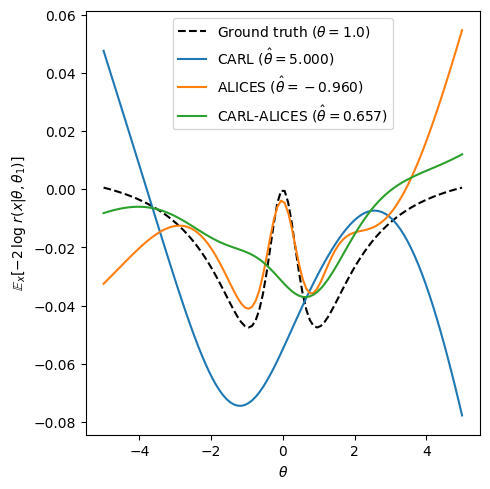

In [72]:
best_fit_alices = float(theta_grid[np.argmin(nllr_test_alices)])
best_fit_carl = float(theta_grid[np.argmin(nllr_test_carl)])
best_fit_mix = float(theta_grid[np.argmin(nllr_test_mix)])

fig = plt.figure(figsize=(5, 5))

plt.plot(
    theta_grid,
    nllr_test_true,
    ls="--",
    c="black",
    label=r"Ground truth ($\theta = 1.0$)",
)
plt.plot(
    theta_grid,
    nllr_test_carl,
    label=r"CARL ($\hat{\theta} = " + "{:.3f}$)".format(best_fit_carl),
)
plt.plot(
    theta_grid,
    nllr_test_alices,
    label=r"ALICES ($\hat{\theta} = " + "{:.3f}$)".format(best_fit_alices),
)
plt.plot(
    theta_grid,
    nllr_test_mix,
    label=r"CARL-ALICES ($\hat{\theta} = " + "{:.3f}$)".format(best_fit_mix),
)

plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_x [ -2\, \log \,r(x | \theta, \theta_{1}) ]$")

plt.legend()
plt.tight_layout()
plt.show()

You should see that the new ALICES approach leads to a better approximation of the true likelihood ratio than the CARL estimate. Note that we only trained in the parameter range (-4, 4), so the deviations at the left and right of the plot are to be expected.

(array([  6.,  34.,  72., 158., 238., 214., 164.,  79.,  28.,   7.]),
 array([-6.42304782, -5.05140681, -3.67976581, -2.30812481, -0.9364838 ,
         0.4351572 ,  1.8067982 ,  3.17843921,  4.55008021,  5.92172121,
         7.29336222]),
 <BarContainer object of 10 artists>)

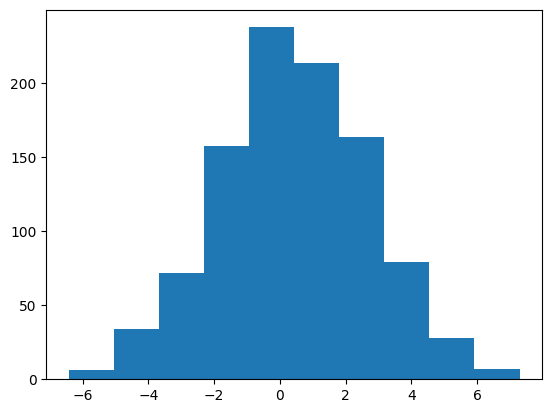

In [53]:
plt.hist(x_test)